# TFM. Modelo predictivo llamadas Call Center
## MVP

## Importacion de librerias 

In [1]:
#import pymssql
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import datetime

pd.options.display.max_columns = None

### Importacion de los datos de envios por oficinas

In [2]:
df_shippings = pd.read_csv('data/shippings.csv', low_memory=False)

In [3]:
df_shippings['Franquicia destino'].unique()

array([4800, 4802, 4803, 4806, 4810])

In [4]:
df = df_shippings[ (df_shippings['Franquicia destino']==4800) ]
#df = df_shippings
df.columns

Index(['Unnamed: 0', 'Fecha envío', 'Número envío', 'Id. Fiscal',
       'Nombre Comercial', 'Código servicio', 'Nombre Rem', 'Población Rem',
       'CP Rem', 'Nombre vía Rem', 'Nombre', 'Población', 'Código postal',
       'Nombre vía', 'Total bultos', 'Franquicia origen', 'Franquicia destino',
       'Total', 'Estado', 'Tipo anomalía', 'Motivo', 'Importe Total'],
      dtype='object')

In [5]:
df = df.iloc[:, [1,5,12,14,15,16]]
df

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino
0,01/01/2020,Urgente 12,07011,1,636,4800
1,01/01/2020,Económico,07003,2,640,4800
2,01/01/2020,Económico,07001,1,642,4800
3,01/01/2020,Urgente 10,07012,1,679,4800
4,01/01/2020,E-commerce,07003,1,2638,4800
...,...,...,...,...,...,...
164142,02/02/2021,Urgente 19,07160,1,4810,4800
164143,02/02/2021,Urgente 19,07014,1,4810,4800
164144,02/02/2021,Urgente 12,07014,1,4810,4800
164145,02/02/2021,Urgente 19,07181,1,4810,4800


In [6]:
df['Fecha envío'] = pd.to_datetime(df['Fecha envío'])

In [7]:
def updateDate(s):
    envio24h = ['Urgente 8:30', 'Urgente 10','Urgente 12','Urgente 14','Urgente 19', \
               'Urgente 8:30 expedición', 'Urgente 10 expedición','Urgente 12 expedición', \
               'Urgente 14 expedición','Urgente 19 expedición','Urgente hoy','Burofax', \
               'Documentos 14','Mascotas','Bag 14','Bag 19','Express documentos']
    envio48h = ['Económico','E-commerce','Mrw economy (ecopaq)','Retorno canje']
    maritimo = ['Marítimo baleares']
    
    nDate = np.nan
    ## Arreglar los 24H
    if s['Código servicio'] in envio24h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=4)
    elif s['Código servicio'] in envio48h:
        nDate = s['Fecha envío'] + datetime.timedelta(days=5)
    else:
        nDate = s['Fecha envío'] + datetime.timedelta(days=6)
    
    if nDate.isoweekday() == 7:
        nDate = nDate + datetime.timedelta(days=1)
    elif nDate.isoweekday() == 6:
        nDate = nDate + datetime.timedelta(days=2)
        
    return nDate

In [8]:
df['xDate'] = df.apply(updateDate, axis=1)

In [9]:
df[df['xDate'].isnull()]

,Fecha envío,Código servicio,Código postal,Total bultos,Franquicia origen,Franquicia destino,xDate


In [10]:
df['Fecha envío'] =  pd.to_datetime(df['xDate']).astype('str')

In [11]:
#Filtro Fecha
#df = df[ df['Fecha envío'] == '2020-02-18' ]

In [12]:
df['Código servicio'].unique()

array(['Urgente 12', 'Económico', 'Urgente 10', 'E-commerce',
       'Urgente 19', 'Mascotas', 'Marítimo baleares', 'Urgente 14',
       'Urgente 19 expedición', 'Urgente 12 expedición', 'Urgente 8:30',
       'Burofax', 'Retorno albarán', 'Bag 14', 'Urgente 10 expedición',
       'Urgente hoy', 'Documentos 14', 'Bag 19',
       'Urgente 8:30 expedición', 'Mrw economy (ecopaq)',
       'Urgente 14 expedición', 'Express documentos', 'Retorno canje'],
      dtype=object)

In [13]:
train = df[['Fecha envío','Código servicio','Franquicia origen','Código postal']]
train.reset_index(inplace=True)
train = train[['Fecha envío','Código servicio','Franquicia origen','Código postal']]
train['total'] = 1

In [14]:
train.head()

,Fecha envío,Código servicio,Franquicia origen,Código postal,total
0,2020-01-06,Urgente 12,636,07011,1
1,2020-01-06,Económico,640,07003,1
2,2020-01-06,Económico,642,07001,1
3,2020-01-06,Urgente 10,679,07012,1
4,2020-01-06,E-commerce,2638,07003,1


In [15]:
train['Franquicia origen'] = train['Franquicia origen'].apply(str)
train['Código postal'] = train['Código postal'].apply(str)

In [16]:
encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['Código servicio']]

In [17]:
encoder.fit(enc.values.reshape(-1,1))
encoder.categories_

[array(['Bag 14', 'Bag 19', 'Burofax', 'Documentos 14', 'E-commerce',
        'Económico', 'Express documentos', 'Marítimo baleares', 'Mascotas',
        'Mrw economy (ecopaq)', 'Retorno albarán', 'Retorno canje',
        'Urgente 10', 'Urgente 10 expedición', 'Urgente 12',
        'Urgente 12 expedición', 'Urgente 14', 'Urgente 14 expedición',
        'Urgente 19', 'Urgente 19 expedición', 'Urgente 8:30',
        'Urgente 8:30 expedición', 'Urgente hoy'], dtype=object)]

In [18]:
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [19]:
train = pd.concat([train,encoded_df], axis=1)

In [20]:
#encoder = OneHotEncoder(handle_unknown='ignore')
#enc = train[['Franquicia origen']]
#encoder.fit(enc.values.reshape(-1,1))
#encoded = encoder.transform(enc.values.reshape(-1,1))
#encoded_df = pd.DataFrame(encoded.todense())
#encoded_df.columns = encoder.categories_[0]

In [21]:
#train = pd.concat([train,encoded_df], axis=1)

In [22]:
encoder = OneHotEncoder(handle_unknown='ignore')
enc = train[['Código postal']]
encoder.fit(enc.values.reshape(-1,1))
encoded = encoder.transform(enc.values.reshape(-1,1))
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = encoder.categories_[0]

In [23]:
train = pd.concat([train,encoded_df], axis=1)

In [24]:
train.drop(columns=['Código servicio','Franquicia origen','Código postal'], inplace=True)

In [25]:
train = train.groupby(['Fecha envío']).sum()

In [26]:
train.head()

,total,Bag 14,Bag 19,Burofax,Documentos 14,E-commerce,Económico,Express documentos,Marítimo baleares,Mascotas,Mrw economy (ecopaq),Retorno albarán,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente hoy,00000,03009,07001,07002,07003,07004,07005,07006,07007,07008,07009,07010,07011,07012,07013,07014,07015,07101,07120,07141,07143,07150,07157,07159,07160,07180,07181,07183,07184,07186,07190,07196,07198,07199,07310,07340,07410,07458,07460,07470,07500,07600,07608,07609,07610,07611,07620,07639,07659,17495,2590,28001,29640,30310,33209,36201,38683,40100,7014,7150,7620,O7002
Fecha envío,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-06,157,0.0,0.0,0.0,0.0,34.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,1.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,6.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,6.0,5.0,5.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,7.0,11.0,25.0,0.0,3.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,8.0,10.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,66,0.0,0.0,0.0,0.0,46.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,3.0,3.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,1.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-08,164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,54.0,1.0,0.0,0.0,0.0,16.0,1.0,54.0,10.0,0.0,0.0,22.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,26.0,7.0,0.0,2.0,11.0,14.0,6.0,0.0,0.0,11.0,14.0,5.0,16.0,16.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,4.0,5.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-09,302,0.0,0.0,0.0,0.0,160.0,48.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,26.0,11.0,0.0,6.0,27.0,15.0,16.0,0.0,0.0,19.0,18.0,20.0,13.0,38.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0,2.0,6.0,11.0,1.0,5.0,0.0,0.0,0.0,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,11.0,6.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-10,357,0.0,0.0,1.0,0.0,8.0,3.0,0.0,246.0,4.0,0.0,0.0,0.0,13.0,1.0,48.0,2.0,0.0,0.0,27.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,16.0,0.0,22.0,15.0,19.0,20.0,0.0,0.0,33.0,9.0,22.0,37.0,23.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,3.0,24.0,33.0,1.0,5.0,0.0,0.0,0.0,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,6.0,8.0,0.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Importacion de los datos de llamadas por oficinas

In [27]:
df_calls = pd.read_csv('data/calls.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
df_calls['sTelefonoCliente'].unique()

array([nan])

In [29]:
df_calls = df_calls[['tCreacion','tInicio','tFinal','idCampanya']]
#df_calls.drop(df_calls.index[df_calls['tInicio'].isnull()], inplace=True)
df_calls

,tCreacion,tInicio,tFinal,idCampanya
0,2020-02-17 10:05:36.853,2020-02-17 10:05:57.313,2020-02-19 00:00:02.263,100000021.0
1,2020-02-17 10:16:49.210,2020-02-17 10:18:08.863,2020-02-19 00:00:02.317,100000023.0
2,2020-02-17 17:05:20.650,2020-02-17 17:05:40.747,2020-02-19 00:00:02.283,100000021.0
3,2020-02-18 07:53:34.653,NaN,2020-02-18 07:53:45.347,100000022.0
4,2020-02-18 08:04:25.990,2020-02-18 08:04:45.580,2020-02-18 08:08:22.533,100000021.0
...,...,...,...,...
186525,2021-02-17 19:43:14.027,2021-02-17 19:44:02.677,2021-02-17 19:47:26.730,100000021.0
186526,2021-02-17 19:47:05.743,2021-02-17 19:48:00.477,2021-02-17 19:49:34.410,100000021.0
186527,2021-02-17 19:51:34.380,NaN,2021-02-17 19:51:47.063,100000023.0
186528,2021-02-17 20:22:41.430,NaN,2021-02-17 20:22:59.940,100000021.0


In [30]:
df_calls['tCreacion'] = pd.to_datetime(df_calls['tCreacion'])
df_calls['tInicio'] = pd.to_datetime(df_calls['tInicio'])
df_calls['tFinal'] = pd.to_datetime(df_calls['tFinal'])
df_calls['Date'] = df_calls['tCreacion'].dt.date
df_calls['Date'] = df_calls['Date'].astype('str') 

In [31]:
df_calls = df_calls[ df_calls['idCampanya'] == 100000015.0 ]

In [32]:
df_calls = df_calls.groupby('Date').count()
df_calls = df_calls[['tCreacion']]
df_calls = df_calls[df_calls.tCreacion > 20]

In [41]:
df_explore = pd.concat([train, df_calls], axis=1).reset_index()
df_explore.dropna(inplace=True)
df_explore.head()

,index,total,Bag 14,Bag 19,Burofax,Documentos 14,E-commerce,Económico,Express documentos,Marítimo baleares,Mascotas,Mrw economy (ecopaq),Retorno albarán,Retorno canje,Urgente 10,Urgente 10 expedición,Urgente 12,Urgente 12 expedición,Urgente 14,Urgente 14 expedición,Urgente 19,Urgente 19 expedición,Urgente 8:30,Urgente 8:30 expedición,Urgente hoy,00000,03009,07001,07002,07003,07004,07005,07006,07007,07008,07009,07010,07011,07012,07013,07014,07015,07101,07120,07141,07143,07150,07157,07159,07160,07180,07181,07183,07184,07186,07190,07196,07198,07199,07310,07340,07410,07458,07460,07470,07500,07600,07608,07609,07610,07611,07620,07639,07659,17495,2590,28001,29640,30310,33209,36201,38683,40100,7014,7150,7620,O7002,tCreacion
31,2020-02-18,599.0,0.0,0.0,3.0,0.0,216.0,88.0,0.0,133.0,1.0,1.0,0.0,0.0,33.0,5.0,73.0,8.0,0.0,0.0,23.0,11.0,2.0,2.0,0.0,0.0,0.0,15.0,44.0,31.0,0.0,8.0,27.0,35.0,30.0,0.0,0.0,37.0,32.0,38.0,53.0,81.0,0.0,0.0,0.0,0.0,7.0,8.0,1.0,8.0,29.0,39.0,3.0,13.0,0.0,0.0,0.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,6.0,9.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0
32,2020-02-19,561.0,0.0,0.0,0.0,0.0,151.0,83.0,0.0,323.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,95.0,21.0,0.0,20.0,17.0,31.0,23.0,0.0,0.0,37.0,64.0,31.0,33.0,66.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,1.0,14.0,18.0,0.0,1.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,4.0,16.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0
33,2020-02-20,288.0,0.0,0.0,0.0,0.0,26.0,1.0,0.0,255.0,0.0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,55.0,11.0,0.0,9.0,3.0,14.0,7.0,0.0,0.0,15.0,26.0,10.0,11.0,52.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,7.0,14.0,0.0,2.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,8.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.0
34,2020-02-21,303.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,55.0,8.0,0.0,0.0,0.0,43.0,4.0,97.0,21.0,0.0,0.0,46.0,18.0,3.0,2.0,0.0,0.0,0.0,6.0,48.0,18.0,0.0,0.0,14.0,31.0,12.0,0.0,0.0,26.0,29.0,13.0,27.0,27.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,5.0,10.0,1.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,5.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167.0
35,2020-02-24,2450.0,0.0,0.0,10.0,0.0,589.0,327.0,0.0,858.0,19.0,0.0,4.0,0.0,165.0,18.0,249.0,64.0,2.0,0.0,87.0,37.0,18.0,3.0,0.0,0.0,0.0,55.0,345.0,118.0,0.0,50.0,136.0,182.0,112.0,0.0,0.0,178.0,231.0,152.0,174.0,192.0,0.0,0.0,0.0,0.0,25.0,12.0,1.0,22.0,61.0,73.0,3.0,16.0,0.0,0.0,3.0,61.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,6.0,40.0,45.0,13.0,83.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
df_subset = df_explore.iloc[:,[0,1]]
df_subtotal = df_explore.iloc[:,-1]
df_subtotal = pd.concat([df_subset, df_subtotal], axis=1)
df_subtotal.head()

,index,total,tCreacion
31,2020-02-18,599.0,160.0
32,2020-02-19,561.0,195.0
33,2020-02-20,288.0,176.0
34,2020-02-21,303.0,167.0
35,2020-02-24,2450.0,196.0


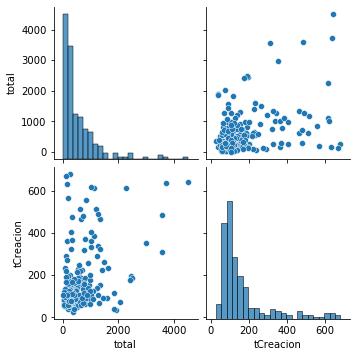

In [36]:
sns.pairplot(df_subtotal);

In [37]:
x=df_subtotal['index']
envios=df_explore['total']
llamadas=df_explore['tCreacion']

envio24h = df_explore['Urgente 8:30'] + df_explore['Urgente 10'] + df_explore['Urgente 12'] + \
    df_explore['Urgente 14'] + df_explore['Urgente 19'] + df_explore['Urgente 8:30 expedición'] + \
    df_explore['Urgente 10 expedición'] + df_explore['Urgente 12 expedición'] + df_explore['Urgente 14 expedición'] + \
    df_explore['Urgente 19 expedición'] + df_explore['Urgente hoy'] + df_explore['Burofax'] + \
    df_explore['Documentos 14'] + df_explore['Mascotas'] + df_explore['Bag 14'] + \
    df_explore['Bag 19'] + df_explore['Express documentos']

envio48h = df_explore['Económico'] + df_explore['E-commerce'] + df_explore['Mrw economy (ecopaq)'] + \
    df_explore['Retorno canje']

maritimo = df_explore[['Marítimo baleares']]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


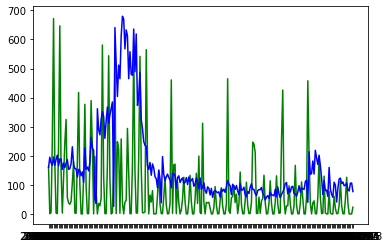

In [38]:
plt.plot(x, envio24h, c='green')
plt.plot(x, llamadas, c='blue');

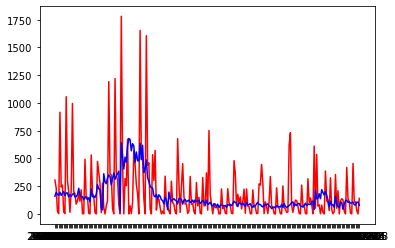

In [39]:
plt.plot(x, envio48h, c='red')
plt.plot(x, llamadas, c='blue');

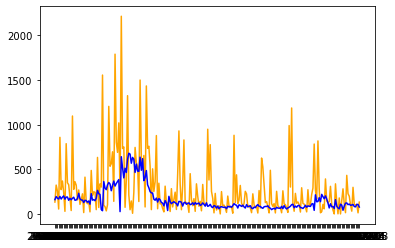

In [40]:
plt.plot(x, maritimo, c='orange')
plt.plot(x, llamadas, c='blue');